In [45]:
from mlscorecheck.auc import acc_from_auc, auc_from_sens_spec
import common_datasets.binary_classification as binclas
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import wilcoxon

In [46]:
classifiers = [
    (RandomForestClassifier, {'max_depth': 5, 'random_state': 5}),
    (DecisionTreeClassifier, {'max_depth': 5, 'random_state': 5}),
    (SVC, {'probability': True, 'C': 0.1}),
    (KNeighborsClassifier, {'n_neighbors': 11})
]

In [47]:
def generate_random_classifier(random_state):
    mode = random_state.randint(4)
    if mode == 0:
        classifier = RandomForestClassifier
        params = {'max_depth': random_state.randint(3, 10),
                  'random_state': 5}
    if mode == 1:
        classifier = DecisionTreeClassifier
        params = {'max_depth': random_state.randint(3, 10),
                  'random_state': 5}
    if mode == 2:
        classifier = SVC
        params = {'probability': True, 'C': random_state.rand()*2 + 0.001}
    if mode == 3:
        classifier = KNeighborsClassifier
        params = {'n_neighbors': random_state.randint(1, 10)}
    
    return (classifier, params)

In [48]:
datasets = binclas.get_filtered_data_loaders(n_col_bounds=(0, 50), n_bounds=(0, 2000), n_minority_bounds=(20, 1000), n_from_phenotypes=1, imbalance_ratio_bounds=(0.2, 8.0))

In [49]:
len(datasets)

20

In [50]:
results = []
random_state = np.random.RandomState(5)

for _ in range(20):
    for loader in datasets:
        dataset = loader()
        X = dataset['data']
        y = dataset['target']
        name = dataset['name']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
        classifier = generate_random_classifier(random_state)

        classifier_obj = classifier[0](**classifier[1])

        classifier_obj.fit(X_train, y_train)
        y_pred = classifier_obj.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred)

        best_th = -1
        best_acc = 0
        for threshold in np.unique(y_pred):
            tp = np.sum((y_pred >= threshold) & (y_test == 1))
            tn = np.sum((y_pred < threshold) & (y_test == 0))
            p = np.sum(y_test)
            n = len(y_test) - np.sum(y_test)

            acc = np.round((tp + tn) / (p + n), 4)
            sens = np.round((tp) / (p), 4)
            spec = np.round((tn) / (n), 4)

            if acc > best_acc:
                best_acc = acc
                best_th = threshold

        threshold = best_th

        tp = np.sum((y_pred >= threshold) & (y_test == 1))
        tn = np.sum((y_pred < threshold) & (y_test == 0))
        p = np.sum(y_test)
        n = len(y_test) - np.sum(y_test)

        acc = np.round((tp + tn) / (p + n), 4)
        sens = np.round((tp) / (p), 4)
        spec = np.round((tn) / (n), 4)

        scores = {
            'acc': acc,
            'sens': sens,
            'spec': spec
        }

        try:
            auc2_int = auc_from_sens_spec(scores=scores, eps=1e-4, p=p, n=n, lower='cmin', upper='max')
            auc2 = (auc2_int[0] + auc2_int[1]) / 2.0
        except:
            auc2_int = None
            auc2 = None

        try:
            auc0_int = auc_from_sens_spec(scores=scores, eps=1e-4, p=p, n=n, lower='min', upper='max-acc')
            auc0 = (auc0_int[0] + auc0_int[1]) / 2.0
        except:
            auc0_int = None
            auc0 = None

        try:
            auc1_int = auc_from_sens_spec(scores=scores, eps=1e-4, p=p, n=n, lower='cmin', upper='max-acc')
            auc1 = (auc1_int[0] + auc1_int[1]) / 2.0
        except:
            auc1_int = None
            auc1 = None


        results.append((auc, acc, sens, spec, threshold, auc0_int, auc0, auc1_int, auc1, auc2_int, auc2))

In [51]:
data = pd.DataFrame(results, columns=['auc', 'acc', 'sens', 'spec', 'threshold', 'auc0_int', 'auc0', 'auc1_int', 'auc1', 'auc2_int', 'auc2'])

In [52]:
tmp = data[(data['auc1'].notnull()) & (data['auc0'].notnull()) & (data['auc2'].notnull())]

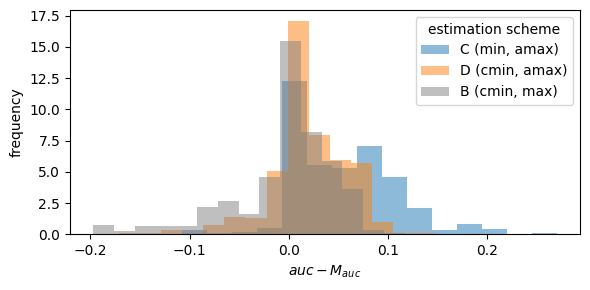

In [53]:
plt.figure(figsize=(6, 3))

plt.hist(tmp['auc'] - tmp['auc0'], density=True, label='C (min, amax)', alpha=0.5, bins=15)
plt.hist(tmp['auc'] - tmp['auc1'], density=True, label='D (cmin, amax)', alpha=0.5, bins=15)
plt.hist(tmp['auc'] - tmp['auc2'], density=True, label='B (cmin, max)', alpha=0.5, bins=15, color='gray')

plt.xlabel(r'$auc - M_{auc}$')
plt.ylabel('frequency')

plt.legend(title='estimation scheme')

plt.tight_layout()
plt.savefig('hist1.png')
plt.show()

In [54]:
np.mean(np.abs((tmp['auc'] - tmp['auc0']))), np.mean(np.abs((tmp['auc'] - tmp['auc1']))),

(np.float64(0.0568261006632605), np.float64(0.031680126374804676))

In [55]:
np.mean(np.abs((tmp['auc'] - tmp['auc0']))), np.mean(np.abs((tmp['auc'] - tmp['auc2']))),

(np.float64(0.0568261006632605), np.float64(0.035476130729129605))

In [56]:
wilcoxon(np.abs((tmp['auc'] - tmp['auc0'])).values, np.abs((tmp['auc'] - tmp['auc1'])).values)

WilcoxonResult(statistic=np.float64(6409.0), pvalue=np.float64(1.692592139008536e-42))

In [57]:
wilcoxon(np.abs((tmp['auc'] - tmp['auc0'])).values, np.abs((tmp['auc'] - tmp['auc2'])).values)

WilcoxonResult(statistic=np.float64(13401.0), pvalue=np.float64(6.559731236104973e-25))